## Tratamiento de datos


# PROYECTO FINAL: Análisis de la polarización ideológica en redes sociales a partir de la propagación de contenidos desinformativos



<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
import re

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from datasets import Dataset as HFDataset

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, f1_score


# 1. ANÁLISIS EXPLORATORIO DEL CONJUNTO DE DATOS


In [4]:
#Carga del dataset
ruta = "/content/drive/MyDrive/PROYECTO_DATOS/WELFake_Dataset.csv"

data = pd.read_csv(ruta)

### 1.1. Descripción general del dataset

Visualizamos el tamaño del dataset, las etiquetas que tenemos, el contenido

In [5]:
#Tamaño de nuestros datos
print("Tamaño de nuestro dataseet:", data.shape)

#Visualizamos las columnas que tienen nuestros datos
print("Columnas Datashet:", data.columns.tolist())

#Tipo de datos
data.dtypes

Tamaño de nuestro dataseet: (72134, 4)
Columnas Datashet: ['Unnamed: 0', 'title', 'text', 'label']


,0
Unnamed: 0,int64
title,object
text,object
label,int64


In [6]:

#Visualizamos las primeras muestras
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
#Valores nulos por columna
print("Nulos:")
print(data.isna().sum())

Nulos:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


### 1.2. Estadísticas y visualizaciones

In [8]:
#Longitud de palabras
'''
Crea una nueva columna en nuestro dataset llamada "Número de palabras" y cuenta las palabras por cada texto

| Parte del código                   | ¿Qué hace?                                                                |
| ---------------------------------- | ------------------------------------------------------------------------- |
| `data["text"]`                     | Toma la columna “text” del dataframe, que contiene las noticias           |
| `.apply(...)`                      | Aplica una función a *cada fila* de esa columna                           |
| `lambda x:`                        | Define una función breve (anónima) llamada `x`, que representa cada texto |
| `str(x)`                           | Convierte el texto en string (por si hay valores no tipo texto)           |
| `.split()`                         | Divide el texto en palabras (separa por espacios)                         |
| `len(...)`                         | Cuenta cuántas palabras hay                                               |
| `data["Número de palabras"] = ...` | Guarda ese número en una nueva columna del dataframe                      |

'''

data["Número de palabras"] = data["text"].apply(lambda x: len(str(x).split()))

In [9]:
#Visualizamos las primeras muestras
#Label --> noticia verdadera / falsa.
data.head()

,Unnamed: 0,title,text,label,Número de palabras
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,871
1,1,NaN,Did they post their votes for Hillary already?,1,8
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,34
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,1321
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,329


In [10]:
#Distribución de clases
data['label'].value_counts()

,count
label,
1,37106
0,35028


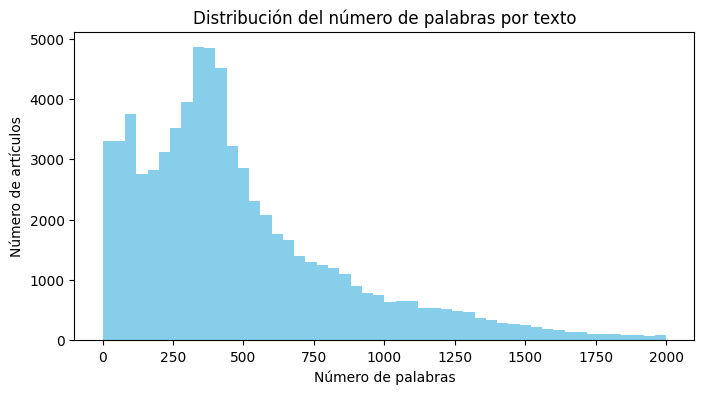

In [11]:
#Distribución del número de palabras por texto
plt.figure(figsize=(8,4))
subset = data[data["Número de palabras"] <= 2000] #solo se toman los articulos que tienen longitud menor o igual a 2000 palabras
plt.hist(subset["Número de palabras"], bins=50, color="skyblue")

plt.xlabel("Número de palabras")
plt.ylabel("Número de artículos")
plt.title("Distribución del número de palabras por texto")
plt.show()


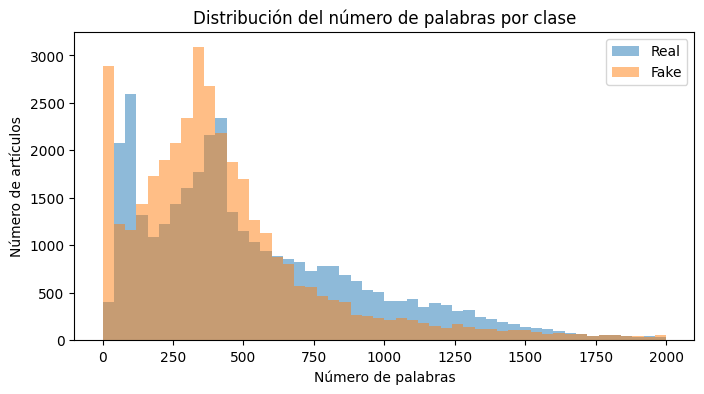

In [12]:
#Distribución del número de palabras por texto por clase

plt.figure(figsize=(8,4))
subset = data[data["Número de palabras"] <= 2000]
plt.hist(subset[subset["label"]==0]["Número de palabras"], bins=50, alpha=0.5, label="Real")
plt.hist(subset[subset["label"]==1]["Número de palabras"], bins=50, alpha=0.5, label="Fake")

plt.xlabel("Número de palabras")
plt.ylabel("Número de artículos")
plt.title("Distribución del número de palabras por clase")
plt.legend()
plt.show()

### 1.3. Análisis preliminar del texto

In [13]:
#Palabras más frecunetes
def get_top_words(series, n=20):
    # Eliminar NaNs y asegurar que todo es str
    series = series.dropna().astype(str)
    words = " ".join(series).lower()
    words = re.findall(r'\b[a-z]{3,}\b', words)
    return Counter(words).most_common(n)

print("Top palabras en REAL:")
print(get_top_words(data[data["label"]==0]["text"], 20))

print("\nTop palabras en FAKE:")
print(get_top_words(data[data["label"]==1]["text"], 20))


Top palabras en REAL:
[('the', 1185992), ('and', 465218), ('that', 259158), ('for', 193669), ('said', 184607), ('with', 133629), ('was', 132623), ('trump', 107201), ('his', 105240), ('has', 97713), ('from', 91539), ('have', 90951), ('not', 89111), ('but', 80207), ('who', 76115), ('are', 73995), ('they', 69580), ('had', 66073), ('this', 64394), ('would', 62514)]

Top palabras en FAKE:
[('the', 1056116), ('and', 449219), ('that', 272567), ('for', 171817), ('with', 118306), ('was', 112608), ('this', 109853), ('trump', 106364), ('are', 98529), ('have', 88690), ('not', 85386), ('they', 84680), ('his', 83705), ('you', 81615), ('from', 78475), ('has', 77834), ('who', 68131), ('but', 64605), ('their', 57459), ('about', 55018)]


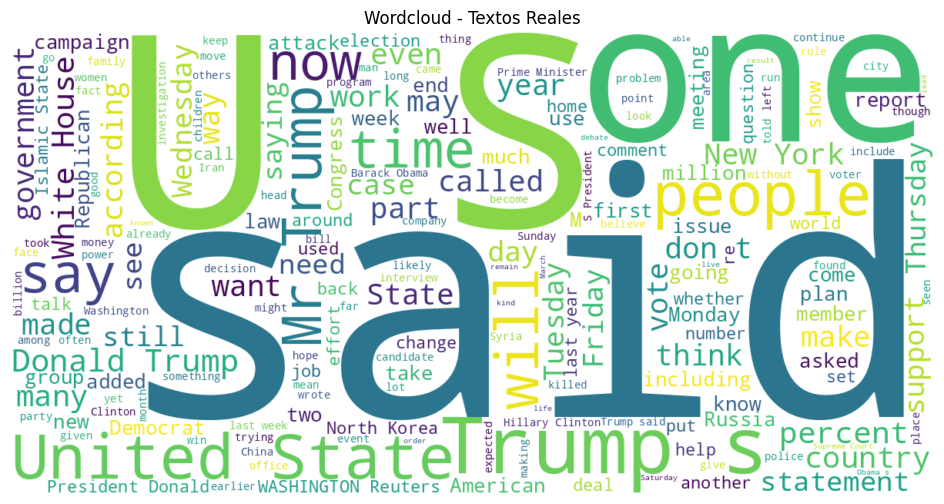

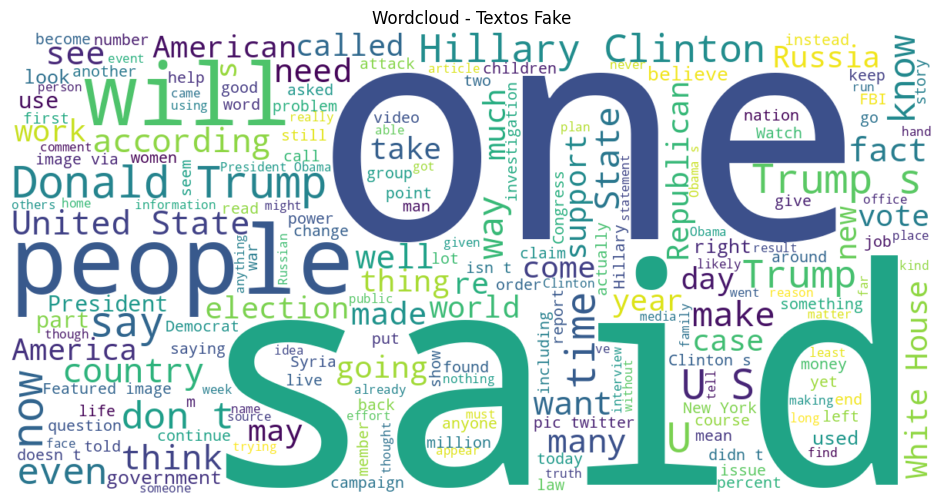

In [14]:
#Nube de palabras
#Unir todos los textos de cada clase
real_text = " ".join(data[data["label"]==0]["text"].astype(str))
fake_text = " ".join(data[data["label"]==1]["text"].astype(str))

#Creamos las nubes
wc_real = WordCloud(width=1200, height=600, background_color='white').generate(real_text)
wc_fake = WordCloud(width=1200, height=600, background_color='white').generate(fake_text)

#Dibujar la cloud de textos reales
plt.figure(figsize=(12,6))
plt.imshow(wc_real, interpolation="bilinear")
plt.title("Wordcloud - Textos Reales")
plt.axis("off")
plt.show()

#Dibujar la cloud de textos fake
plt.figure(figsize=(12,6))
plt.imshow(wc_fake, interpolation="bilinear")
plt.title("Wordcloud - Textos Fake")
plt.axis("off")
plt.show()

In [15]:
#Ejemplos por clase
print("Ejemplo noticia real:\n")
print(data[data["label"]==0]["text"].iloc[1])

print("\n" + "="*100 + "\n")

print("Ejemplo noticia fake:\n")
print(data[data["label"]==1]["text"].iloc[0])


Ejemplo noticia real:

BRUSSELS (Reuters) - British Prime Minister Theresa May s offer of  settled status  for EU residents is flawed and will leave them with fewer rights after Brexit, the European Parliament s Brexit coordinator said on Tuesday. A family of five could face a bill of 360 pounds to acquire the new status, Guy Verhofstadt told May s Brexit Secretary David Davis in a letter seen by Reuters    a very significant amount for a family on low income . Listing three other concerns for the EU legislature, which must approve any treaty on the March 2019 exit, Verhofstadt told Davis:  Under your proposals, EU citizens will definitely notice a deterioration of their status as a result of Brexit. And the Parliament s aim all along has been that EU citizens, and UK citizens in the EU-27, should notice no difference.  Verhofstadt, a former Belgian prime minister, wrote in response to Davis, who had written to him after Parliament complained last week that there remained  major issues

### 1.3.1. CAMBIOS EN EL DATASET

In [16]:
data = data.drop(columns=["Unnamed: 0"], errors='ignore') #Eliminamos la primera columna
data = data.drop(columns=["title"], errors='ignore') #Eliminamos la columna de title
data = data.dropna(subset=["text"]).reset_index(drop=True) #Eliminamos las filas donde text sea nulo

#Cuántas valores nulos tenemos por columna
print("Nulos:")
print(data.isna().sum())

Nulos:
text                  0
label                 0
Número de palabras    0
dtype: int64


In [17]:
data["Número de palabras"].quantile([0.90, 0.95, 0.99]) #Percentiles

,Número de palabras
0.90,1102.0
0.95,1415.0
0.99,2767.0


In [18]:
#Eliminamos del dataset todas las filas donde el texto tenga menos de 200 palabras
data = data[data["Número de palabras"] >= 200]
data = data[data["Número de palabras"] <= 2000]
data = data.reset_index(drop=True) #Reorganizar los índices


In [19]:
#Volvemos a imprimir:
#Tamaño de nuestros datos
print("Tamaño de nuestro dataseet:", data.shape)

#Muestras por clase
data['label'].value_counts()

Tamaño de nuestro dataseet: (54770, 3)


,count
label,
1,27781
0,26989


In [20]:
''' Como las palabras más repetidas son articulos, preposiciones o palabras sin relevancia vamos a:

1. Calcular número de palabras por muestra, pero sin este tipo de palabras

2. Obtener las palabras más frecuentes PERO eliminando stopwords y palabras no informativas

'''
nltk.download('stopwords') #descarga una lista de palabras muy frecuentes
stopwords_en = set(stopwords.words('english')) #Son el conjunto de palabras que queremos eliminar

'''
creamos una función que:
   - pasa el texto a minúsculas
   - elimina todo lo que no sea letra
   - elimina stopwords
   - cuenta las palabras finales
'''

def get_top_words_clean(series, n=20):
    series = series.dropna().astype(str)
    all_words = []

    for text in series:
        tokens = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower()) #pasamos el texto a minúsculas
        tokens = [t for t in tokens if t not in stopwords_en] #de esta lista quitamos las stopwords
        all_words.extend(tokens)

    return Counter(all_words).most_common(n)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
print("Top palabras REAL modificado:")
print(get_top_words_clean(data[data["label"]==0]["text"], 20))

print("\nTop palabras FAKE modificado:")
print(get_top_words_clean(data[data["label"]==1]["text"], 20))

Top palabras REAL modificado:
[('said', 162967), ('trump', 94766), ('would', 55027), ('president', 43728), ('new', 37350), ('one', 36506), ('people', 36082), ('state', 34698), ('also', 32882), ('states', 28325), ('government', 27006), ('could', 26517), ('year', 25313), ('clinton', 24947), ('united', 24518), ('house', 24471), ('two', 24329), ('last', 24111), ('republican', 23882), ('reuters', 22394)]

Top palabras FAKE modificado:
[('trump', 95021), ('said', 43972), ('people', 38665), ('clinton', 37500), ('one', 36235), ('would', 34660), ('president', 32879), ('hillary', 25468), ('like', 25133), ('also', 23006), ('obama', 22780), ('new', 22170), ('donald', 21969), ('time', 20967), ('even', 20689), ('state', 19670), ('news', 18091), ('election', 17061), ('campaign', 16573), ('could', 16240)]


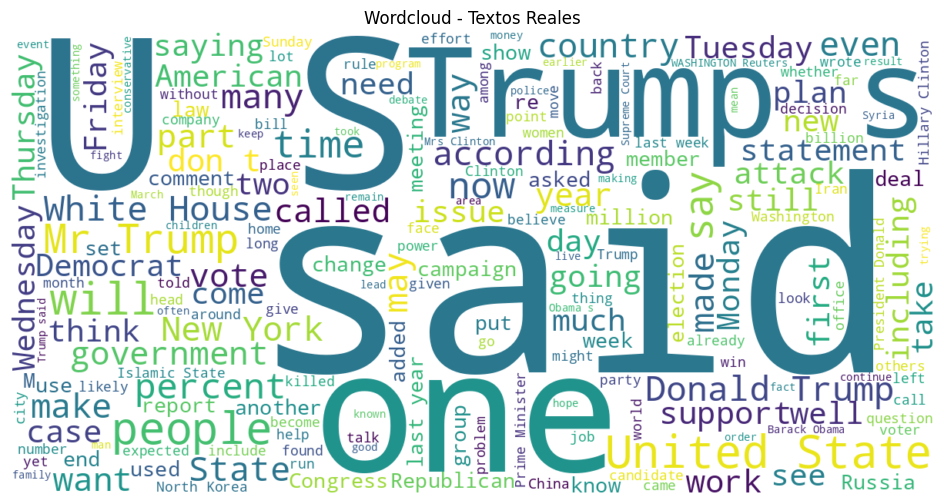

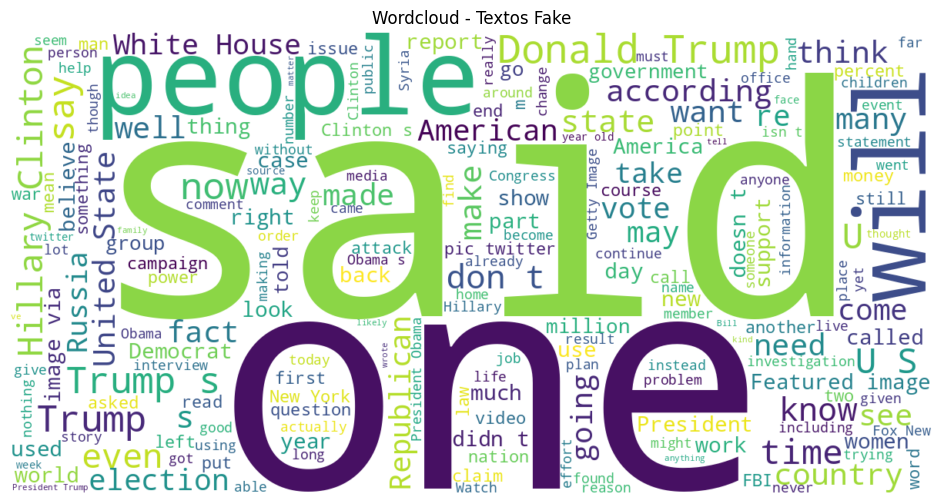

In [ ]:
#Unir todos los textos de cada clase
real_text = " ".join(data[data["label"]==0]["text"].astype(str))
fake_text = " ".join(data[data["label"]==1]["text"].astype(str))

#Creamos las nubes
wc_real = WordCloud(width=1200, height=600, background_color='white').generate(real_text)
wc_fake = WordCloud(width=1200, height=600, background_color='white').generate(fake_text)

#Dibujar la cloud de textos reales
plt.figure(figsize=(12,6))
plt.imshow(wc_real, interpolation="bilinear")
plt.title("Wordcloud - Textos Reales")
plt.axis("off")
plt.show()

#Dibujar la cloud de textos fake
plt.figure(figsize=(12,6))
plt.imshow(wc_fake, interpolation="bilinear")
plt.title("Wordcloud - Textos Fake")
plt.axis("off")
plt.show()

### 1.4. Hipótesis

Las noticias desinformativas emplean un estilo más emocional, sensacionalista y subjetivo que las noticias reales, lo que facilita su difusión dentro de comunidades ideológicamente polarizadas.

Por el contrario, las noticias reales tienden a mantener un estilo más formal, estructurado y acorde con los estándares del periodismo, recurriendo con mayor frecuencia a citas, datos verificables y un lenguaje menos cargado emocionalmente.

# 2.REPRESENTACIÓN VECTORIAL DEL TEXTO

Se aplica un preprocesamiento del texto orientado al modelado, que incluyó normalización a minúsculas, eliminación de símbolos y stopwords, tokenización y conversión de los textos a vectores numéricos mediante TF-IDF, para que puedan ser utilizados como entrada en los modelos de clasificación.

In [22]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text): #recibe el texto y devuelve los tokens limpios
    # Asegurar que es string
    if isinstance(text, list):
        text = " ".join(text)
    if not isinstance(text, str):
        text = str(text)

    tokens = word_tokenize(text) #Tokenización, conversión del texto en una lista
    tokens = [token.lower() for token in tokens if token.isalnum()] #Convertir a minúsculas y eliminar caracteres especiales
    tokens = [token for token in tokens if token not in stop_words] #Eliminar stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #Lematización
    return tokens

#tokens --> lista de palabras limpias
#text_limpio --> texto listo para vectorizar

data["tokens"] = data["text"].apply(preprocess_text)
data[["text", "tokens"]].head()

data["text_limpio"] = data["tokens"].apply(lambda toks: " ".join(toks))
data[["text", "text_limpio"]].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,text_limpio
0,No comment is expected from Barack Obama Membe...,comment expected barack obama member fyf911 fu...
1,A dozen politically active pastors came here f...,dozen politically active pastor came private d...
2,"The RS-28 Sarmat missile, dubbed Satan 2, will...",sarmat missile dubbed satan 2 replace fly mile...
3,All we can say on this one is it s about time ...,say one time someone sued southern poverty law...
4,"The owner of the Ringling Bar, located south o...",owner ringling bar located south white sulphur...


#DIVISIÓN DE LOS DATOS

In [23]:
X = data.index
y = data["label"] #será lo que se quiere predecir

#Train 60%, Val 20% y Test 20%
#División train y temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
#División validación y test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Tamaño de train:", len(X_train))
print("Tamaño de validación:", len(X_val))
print("Tamaño de test:", len(X_test))

#Para word2Vec necesitamos hacer la división de los datos utilizando tokens
X_train_tokens = data.loc[X_train, "tokens"]
X_val_tokens = data.loc[X_val, "tokens"]
X_test_tokens = data.loc[X_test, "tokens"]

print("Tamaño de train TOKENS:", len(X_train_tokens))
print("Tamaño de validación TOKENS:", len(X_val_tokens))
print("Tamaño de test TOKENS:", len(X_test_tokens))


Tamaño de train: 32862
Tamaño de validación: 10954
Tamaño de test: 10954
Tamaño de train TOKENS: 32862
Tamaño de validación TOKENS: 10954
Tamaño de test TOKENS: 10954


### 2.1. VECTORIZACIÓN CON TF-IDF


TF - Term frequency : Cuántas veces aparece una palabra en un texto

IDF — Inverse Document Frequency:IDF mide cuánto discrimina una palabra entre documentos. Si una palabra aparece en todos los documentos, no es informativa (articulos). Si una palabra aparece en pocos documentos, es informativa.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000, #se queda con las 20.000 palabras más frecuentes
    ngram_range=(1,2), #creación de dos tipos de tokens
    min_df=5 #deben aparecer en 5 noticias
)


X_train_text = data.loc[X_train, "text_limpio"]
X_val_text   = data.loc[X_val,   "text_limpio"]
X_test_text  = data.loc[X_test,  "text_limpio"]

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape


((32862, 20000), (10954, 20000), (10954, 20000))

### 2.2. VECTORIZACIÓN CON Word2Vec

Aprende representaciones numéricas de palabras:


*   Palabras parecidas están cerca.
*   Palabras diferentes están lejos.



In [25]:
!pip install gensim

from gensim.models import Word2Vec

w2v = Word2Vec(
    sentences=X_train_tokens,
    vector_size=300,
    window=2,
    min_count=20,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=20,
    sg=1
)

def doc_to_vec(tokens):
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    if len(vecs) == 0:
        return np.zeros(w2v.vector_size)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack([doc_to_vec(t) for t in X_train_tokens])
X_val_w2v   = np.vstack([doc_to_vec(t) for t in X_val_tokens])
X_test_w2v  = np.vstack([doc_to_vec(t) for t in X_test_tokens])

X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 33.1 MB/s eta 0:00:00


((32862, 300), (10954, 300), (10954, 300))

### 2.3 Embeddings contextuales (BERT)



In [ ]:
!pip install -q transformers

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
model_name = "distilbert-base-uncased"   # minúsculas, inglés

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usaremos:", device)

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)
bert_model.eval();  # modo evaluación, no entrenamos aquí

def get_bert_embeddings(text_series, batch_size=16, max_length=256):

    all_embeddings = []
    texts = text_series.astype(str).tolist()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids,
                                 attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state   # (batch, seq_len, hidden)

            # mean pooling con máscara (solo tokens válidos)
            mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            masked = last_hidden_state * mask
            summed = masked.sum(dim=1)
            counts = mask.sum(dim=1)
            mean_pooled = summed / counts                    # (batch, hidden_dim)

        all_embeddings.append(mean_pooled.cpu().numpy())

    return np.vstack(all_embeddings)

    # Textos limpios de cada partición
X_train_text = data.loc[X_train, "text_limpio"]
X_val_text   = data.loc[X_val,   "text_limpio"]
X_test_text  = data.loc[X_test,  "text_limpio"]

# Obtenemos los embeddings BERT
X_train_bert = get_bert_embeddings(X_train_text)
X_val_bert   = get_bert_embeddings(X_val_text)
X_test_bert  = get_bert_embeddings(X_test_text)

X_train_bert.shape, X_val_bert.shape, X_test_bert.shape



Usaremos: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

((32862, 768), (10954, 768), (10954, 768))

#3. MODELOS

###3.1. LOGISTIC REGRESSION

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logreg = LogisticRegression(
    max_iter=300,
    C=1.0,
    class_weight="balanced",  # por si hay ligera descompensación
    n_jobs=-1                 # usar todos los cores si tu entorno lo permite
)

###3.2. SVM

In [28]:
#SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

svm_clf = LinearSVC()

###3.3. KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

knn_clf = KNeighborsClassifier()

#GridSearch sobre train
grid_search_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid={'n_neighbors': [3, 5, 7, 9, 11]},
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

###3.4. Red Neuronal

In [30]:
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import issparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
import time, copy, random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class VectorDataset(Dataset):
    def __init__(self, X, y):
        """
        X puede ser:
          - matriz scipy.sparse (TF-IDF)
          - numpy array (Word2Vec, BERT embeddings)
          - torch.Tensor
        y puede ser pandas.Series, np.array, etc.
        """
        self.X = X
        # Guardamos las etiquetas como array 1D
        self.y = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Extraemos la fila X[idx]
        if issparse(self.X):
            # fila sparse -> denso (1, n_features) -> (n_features,)
            x_row = self.X[idx].toarray().astype(np.float32).squeeze(0)
        elif isinstance(self.X, torch.Tensor):
            x_row = self.X[idx].detach().cpu().numpy().astype(np.float32)
        else:
            # asumimos numpy array o similar
            x_row = np.asarray(self.X[idx], dtype=np.float32)

        y_val = np.float32(self.y[idx])

        x_tensor = torch.from_numpy(x_row)
        y_tensor = torch.tensor(y_val, dtype=torch.float32)

        return x_tensor, y_tensor

def create_dataloaders(X_train, y_train, X_val, y_val, batch_size=64):
    train_dataset = VectorDataset(X_train, y_train)
    val_dataset   = VectorDataset(X_val,   y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    dataloaders = {"train": train_loader, "val": val_loader}
    sizes = {"train": len(train_dataset), "val": len(val_dataset)}
    return dataloaders, sizes

class CustomNet(nn.Module):
    def __init__(self, in_features):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x.squeeze(1)


def computeAUC(outputs, labels):
    try:
        return roc_auc_score(labels, outputs)
    except:
        return 0.0


class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_auc = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, auc):
        if self.best_auc is None:
            self.best_auc = auc
        elif auc < self.best_auc + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"No mejora en AUC. Patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_auc = auc
            self.counter = 0


def train_model(model, criterion, optimizer, scheduler, dataset_sizes, dataloaders, num_epochs=15):
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.backends.cudnn.benchmark = False

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            numSamples = dataset_sizes[phase]
            outputs_m = np.zeros((numSamples,), dtype=np.float32)
            labels_m  = np.zeros((numSamples,), dtype=int)
            running_loss = 0.0
            contSamples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    logits = model(inputs)
                    loss = criterion(logits, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                probs = torch.sigmoid(logits).detach().cpu().numpy()
                bs = len(labels)
                outputs_m[contSamples:contSamples+bs] = probs
                labels_m[contSamples:contSamples+bs]  = labels.cpu().numpy().astype(int)
                contSamples += bs

            if phase == "train" and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            auc = computeAUC(outputs_m, labels_m)
            preds_bin = (outputs_m >= 0.5).astype(int)
            acc = accuracy_score(labels_m, preds_bin)
            prec = precision_score(labels_m, preds_bin)

            print(f"{phase} Loss: {epoch_loss:.4f} AUC: {auc:.4f} Acc: {acc:.4f} Prec: {prec:.4f}")

            if phase == "val":
                if auc > best_auc:
                    best_auc = auc
                    best_model_wts = copy.deepcopy(model.state_dict())

                early_stopping(auc)
                if early_stopping.early_stop:
                    print(f"Parada temprana en epoch {epoch+1}")
                    model.load_state_dict(best_model_wts)
                    return model

        print()

    model.load_state_dict(best_model_wts)
    return model


Device: cpu


#4. ENTRENAMIENTO

###4.1. VECTORIZACIÓN CON TF-IDF

In [31]:
#Entrenamos Logistic Regression
logreg.fit(X_train_tfidf, y_train)

#Predicciones
y_train_pred_lr = logreg.predict(X_train_tfidf)
y_val_pred_lr = logreg.predict(X_val_tfidf)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_lr))
print(classification_report(y_train, y_train_pred_lr))
print("Accuracy (val):", accuracy_score(y_val, y_val_pred_lr))
print(classification_report(y_val, y_val_pred_lr))

#Test
y_test_pred_lr = logreg.predict(X_test_tfidf)
print(accuracy_score(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr))



Accuracy (train): 0.9572150203882904
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     16193
           1       0.95      0.96      0.96     16669

    accuracy                           0.96     32862
   macro avg       0.96      0.96      0.96     32862
weighted avg       0.96      0.96      0.96     32862

Accuracy (val): 0.9375570567829103
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5398
           1       0.93      0.95      0.94      5556

    accuracy                           0.94     10954
   macro avg       0.94      0.94      0.94     10954
weighted avg       0.94      0.94      0.94     10954

0.9374657659302538
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5398
           1       0.93      0.94      0.94      5556

    accuracy                           0.94     10954
   macro avg       0.94      0.94    

In [34]:
#Entrenamos SVM
svm_clf.fit(X_train_tfidf, y_train)

#Predicciones
y_train_pred_svm = svm_clf.predict(X_train_tfidf)
y_val_pred_svm = svm_clf.predict(X_val_tfidf)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_svm))
print(classification_report(y_train, y_train_pred_svm))
print("Accuracy (val) SVM:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm))

#Test
y_test_pred_svm = svm_clf.predict(X_test_tfidf)
print(accuracy_score(y_test, y_test_pred_svm))
print(classification_report(y_test, y_test_pred_svm))


Accuracy (train): 0.9949181425354513
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     16193
           1       0.99      1.00      0.99     16669

    accuracy                           0.99     32862
   macro avg       0.99      0.99      0.99     32862
weighted avg       0.99      0.99      0.99     32862

Accuracy (val) SVM: 0.954171991966405
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5398
           1       0.95      0.96      0.96      5556

    accuracy                           0.95     10954
   macro avg       0.95      0.95      0.95     10954
weighted avg       0.95      0.95      0.95     10954

0.9537155377031221
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5398
           1       0.95      0.96      0.95      5556

    accuracy                           0.95     10954
   macro avg       0.95      0.95 

In [ ]:
#Entrenamos KNN
grid_search_knn.fit(X_train_tfidf, y_train)

print("Mejores hiperparámetros:", grid_search_knn.best_params_)
print("Mejor score (cv):", grid_search_knn.best_score_)

#Extraemos el mejor modelo
best_knn = grid_search_knn.best_estimator_

#Predicciones
y_train_pred_knn = best_knn.predict(X_train_tfidf)
y_val_pred_knn   = best_knn.predict(X_val_tfidf)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_knn))
print(classification_report(y_train, y_train_pred_knn))
print("Accuracy (val):", accuracy_score(y_val, y_val_pred_knn))
print(classification_report(y_val, y_val_pred_knn))

#Test
y_test_pred_knn = best_knn.predict(X_test_tfidf)
print(accuracy_score(y_test, y_test_pred_knn))
print(classification_report(y_test, y_test_pred_knn))


Mejores hiperparámetros: {'n_neighbors': 5}
Mejor score (cv): 0.7828494918142536
Accuracy (train): 0.8598381108879557
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     16193
           1       0.91      0.80      0.85     16669

    accuracy                           0.86     32862
   macro avg       0.86      0.86      0.86     32862
weighted avg       0.87      0.86      0.86     32862

Accuracy (val): 0.7918568559430345
              precision    recall  f1-score   support

           0       0.74      0.88      0.81      5398
           1       0.86      0.70      0.77      5556

    accuracy                           0.79     10954
   macro avg       0.80      0.79      0.79     10954
weighted avg       0.80      0.79      0.79     10954

0.7920394376483476
              precision    recall  f1-score   support

           0       0.74      0.88      0.81      5398
           1       0.86      0.71      0.78      5556

    accura

In [ ]:
#Entrenamos Red Neuronal
# X_train_tfidf, X_val_tfidf son matrices sparse
dataloaders_tfidf, sizes_tfidf = create_dataloaders(
    X_train_tfidf, y_train,
    X_val_tfidf,   y_val,
    batch_size=64
)

in_dim_tfidf = X_train_tfidf.shape[1]
model_tfidf = CustomNet(in_features=in_dim_tfidf).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_tfidf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model_tfidf = train_model(
    model=model_tfidf,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataset_sizes=sizes_tfidf,
    dataloaders=dataloaders_tfidf,
    num_epochs=15
)

# Crear dataset y dataloader de test
test_dataset_tfidf = VectorDataset(X_test_tfidf, y_test)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=64, shuffle=False)

model_tfidf.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader_tfidf:
        x_batch = x_batch.to(device).float()
        logits = model_tfidf(x_batch)

        probs = torch.sigmoid(logits).cpu().numpy()
        labels_np = y_batch.numpy().astype(int)

        all_probs.extend(probs)
        all_labels.extend(labels_np)

# Convertir a arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Predicción binaria
preds = (all_probs >= 0.5).astype(int)

# Métricas finales

print("Accuracy :", accuracy_score(all_labels, preds))
print("AUC      :", roc_auc_score(all_labels, all_probs))
print()
print(classification_report(all_labels, preds))



Epoch 1/15
--------------------
train Loss: 0.1887 AUC: 0.9784 Acc: 0.9264 Prec: 0.9257
val Loss: 0.1269 AUC: 0.9899 Acc: 0.9531 Prec: 0.9486

Epoch 2/15
--------------------
train Loss: 0.0393 AUC: 0.9990 Acc: 0.9869 Prec: 0.9862
val Loss: 0.1530 AUC: 0.9889 Acc: 0.9490 Prec: 0.9486
No mejora en AUC. Patience: 1/3

Epoch 3/15
--------------------
train Loss: 0.0232 AUC: 0.9996 Acc: 0.9918 Prec: 0.9915
val Loss: 0.1694 AUC: 0.9888 Acc: 0.9513 Prec: 0.9465
No mejora en AUC. Patience: 2/3

Epoch 4/15
--------------------
train Loss: 0.0105 AUC: 0.9999 Acc: 0.9970 Prec: 0.9974
val Loss: 0.1751 AUC: 0.9905 Acc: 0.9527 Prec: 0.9593

Epoch 5/15
--------------------
train Loss: 0.0032 AUC: 1.0000 Acc: 0.9994 Prec: 0.9994
val Loss: 0.1870 AUC: 0.9905 Acc: 0.9533 Prec: 0.9489

Epoch 6/15
--------------------
train Loss: 0.0021 AUC: 1.0000 Acc: 0.9995 Prec: 0.9992
val Loss: 0.1994 AUC: 0.9904 Acc: 0.9536 Prec: 0.9551
No mejora en AUC. Patience: 1/3

Epoch 7/15
--------------------
train Loss: 0.

### 4.2. VECTORIZACIÓN CON Word2Vec

In [ ]:
#Entrenamos Logistic Regression
logreg.fit(X_train_w2v, y_train)

#Predicciones
y_train_pred_lr_w2v = logreg.predict(X_train_w2v)
y_val_pred_lr_w2v = logreg.predict(X_val_w2v)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_lr_w2v))
print(classification_report(y_train, y_train_pred_lr_w2v))
print("Accuracy (val):", accuracy_score(y_val, y_val_pred_lr_w2v))
print(classification_report(y_val, y_val_pred_lr_w2v))

#Test
y_test_pred_lr_w2v = logreg.predict(X_test_w2v)
print(accuracy_score(y_test, y_test_pred_lr_w2v))
print(classification_report(y_test, y_test_pred_lr_w2v))

Accuracy (train): 0.8955024039924533
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     16193
           1       0.90      0.89      0.90     16669

    accuracy                           0.90     32862
   macro avg       0.90      0.90      0.90     32862
weighted avg       0.90      0.90      0.90     32862

Accuracy (val): 0.8937374475077597
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5398
           1       0.89      0.90      0.90      5556

    accuracy                           0.89     10954
   macro avg       0.89      0.89      0.89     10954
weighted avg       0.89      0.89      0.89     10954

0.8948329377396385
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      5398
           1       0.90      0.89      0.90      5556

    accuracy                           0.89     10954
   macro avg       0.89      0.89    

In [ ]:
#Entrenamos SVM
svm_clf.fit(X_train_w2v, y_train)

#Predicciones
y_train_pred_svm_w2v = svm_clf.predict(X_train_w2v)
y_val_pred_svm_w2v = svm_clf.predict(X_val_w2v)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_svm_w2v))
print(classification_report(y_train, y_train_pred_svm_w2v))
print("Accuracy (val) SVM:", accuracy_score(y_val, y_val_pred_svm_w2v))
print(classification_report(y_val, y_val_pred_svm_w2v))

#Test
y_test_pred_svm_w2v = svm_clf.predict(X_test_w2v)
print(accuracy_score(y_test, y_test_pred_svm_w2v))
print(classification_report(y_test, y_test_pred_svm_w2v))

Accuracy (train): 0.9017406122573185
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     16193
           1       0.91      0.90      0.90     16669

    accuracy                           0.90     32862
   macro avg       0.90      0.90      0.90     32862
weighted avg       0.90      0.90      0.90     32862

Accuracy (val) SVM: 0.8976629541719919
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5398
           1       0.90      0.90      0.90      5556

    accuracy                           0.90     10954
   macro avg       0.90      0.90      0.90     10954
weighted avg       0.90      0.90      0.90     10954

0.9006755523096586
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5398
           1       0.91      0.90      0.90      5556

    accuracy                           0.90     10954
   macro avg       0.90      0.90

In [ ]:
#Entrenamos KNN
grid_search_knn.fit(X_train_w2v, y_train)

print("Mejores hiperparámetros:", grid_search_knn.best_params_)
print("Mejor score (cv):", grid_search_knn.best_score_)

#Extraemos el mejor modelo
best_knn = grid_search_knn.best_estimator_

#Predicciones
y_train_pred_knn_w2v = best_knn.predict(X_train_w2v)
y_val_pred_knn_w2v   = best_knn.predict(X_val_w2v)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_knn_w2v))
print(classification_report(y_train, y_train_pred_knn_w2v))
print("Accuracy (val):", accuracy_score(y_val, y_val_pred_knn_w2v))
print(classification_report(y_val, y_val_pred_knn_w2v))

#Test
y_test_pred_knn_w2v = best_knn.predict(X_test_w2v)
print(accuracy_score(y_test, y_test_pred_knn_w2v))
print(classification_report(y_test, y_test_pred_knn_w2v))

Mejores hiperparámetros: {'n_neighbors': 5}
Mejor score (cv): 0.816444525591869
Accuracy (train): 0.880287261883026
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16193
           1       0.95      0.81      0.87     16669

    accuracy                           0.88     32862
   macro avg       0.89      0.88      0.88     32862
weighted avg       0.89      0.88      0.88     32862

Accuracy (val): 0.8237173635201753
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      5398
           1       0.92      0.72      0.81      5556

    accuracy                           0.82     10954
   macro avg       0.84      0.83      0.82     10954
weighted avg       0.84      0.82      0.82     10954

0.8251780171626802
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      5398
           1       0.92      0.72      0.81      5556

    accuracy

In [ ]:
#Entrenamos Red Neuronal
# X_train_tfidf, X_val_tfidf son matrices sparse
dataloaders_w2v, sizes_w2v = create_dataloaders(
    X_train_w2v, y_train,
    X_val_w2v,   y_val,
    batch_size=64
)

in_dim_w2v = X_train_w2v.shape[1]
model_w2v = CustomNet(in_features=in_dim_w2v).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_w2v.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model_w2v = train_model(
    model=model_w2v,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataset_sizes=sizes_w2v,
    dataloaders=dataloaders_w2v,
    num_epochs=15
)


# Crear dataset y dataloader de test
test_dataset_w2v = VectorDataset(X_test_w2v, y_test)
test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=64, shuffle=False)

model_tfidf.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader_w2v:
        x_batch = x_batch.to(device).float()
        logits = model_w2v(x_batch)

        probs = torch.sigmoid(logits).cpu().numpy()
        labels_np = y_batch.numpy().astype(int)

        all_probs.extend(probs)
        all_labels.extend(labels_np)

# Convertir a arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Predicción binaria
preds = (all_probs >= 0.5).astype(int)

# Métricas finales

print("Accuracy :", accuracy_score(all_labels, preds))
print("AUC      :", roc_auc_score(all_labels, all_probs))
print()
print(classification_report(all_labels, preds))

Epoch 1/15
--------------------
train Loss: 0.2648 AUC: 0.9577 Acc: 0.8901 Prec: 0.8923
val Loss: 0.2216 AUC: 0.9725 Acc: 0.9093 Prec: 0.9360

Epoch 2/15
--------------------
train Loss: 0.2014 AUC: 0.9752 Acc: 0.9189 Prec: 0.9203
val Loss: 0.2004 AUC: 0.9757 Acc: 0.9188 Prec: 0.9151

Epoch 3/15
--------------------
train Loss: 0.1817 AUC: 0.9798 Acc: 0.9271 Prec: 0.9292
val Loss: 0.2002 AUC: 0.9765 Acc: 0.9197 Prec: 0.9060

Epoch 4/15
--------------------
train Loss: 0.1516 AUC: 0.9858 Acc: 0.9421 Prec: 0.9424
val Loss: 0.1865 AUC: 0.9804 Acc: 0.9264 Prec: 0.9474

Epoch 5/15
--------------------
train Loss: 0.1376 AUC: 0.9883 Acc: 0.9467 Prec: 0.9462
val Loss: 0.1833 AUC: 0.9815 Acc: 0.9267 Prec: 0.9507

Epoch 6/15
--------------------
train Loss: 0.1245 AUC: 0.9905 Acc: 0.9514 Prec: 0.9513
val Loss: 0.1820 AUC: 0.9815 Acc: 0.9305 Prec: 0.9479

Epoch 7/15
--------------------
train Loss: 0.1055 AUC: 0.9932 Acc: 0.9602 Prec: 0.9591
val Loss: 0.1810 AUC: 0.9809 Acc: 0.9312 Prec: 0.9422


### 4.3 Embeddings contextuales (BERT)

In [ ]:
#Entrenamos con logisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg_bert = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    n_jobs=-1
)

logreg_bert.fit(X_train_bert, y_train)

y_train_pred_lr_bert = logreg_bert.predict(X_train_bert)
y_val_pred_lr_bert   = logreg_bert.predict(X_val_bert)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_lr_bert))
print(classification_report(y_train, y_train_pred_lr_bert))

print("Accuracy (val):", accuracy_score(y_val, y_val_pred_lr_bert))
print(classification_report(y_val, y_val_pred_lr_bert))

y_test_pred_lr_bert   = logreg_bert.predict(X_test_bert)
print("Accuracy (test):", accuracy_score(y_test, y_test_pred_lr_bert))
print(classification_report(y_test, y_test_pred_lr_bert))

Accuracy (train): 0.8864037490110158
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     16193
           1       0.89      0.89      0.89     16669

    accuracy                           0.89     32862
   macro avg       0.89      0.89      0.89     32862
weighted avg       0.89      0.89      0.89     32862

Accuracy (val): 0.8859777250319518
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      5398
           1       0.89      0.89      0.89      5556

    accuracy                           0.89     10954
   macro avg       0.89      0.89      0.89     10954
weighted avg       0.89      0.89      0.89     10954

Accuracy (test): 0.881139309841154
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5398
           1       0.88      0.89      0.88      5556

    accuracy                           0.88     10954
   macro avg       0.

In [ ]:
#BERT + SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_bert = LinearSVC()

# Entrenamos SVM con los embeddings BERT
svm_bert.fit(X_train_bert, y_train)

# Predicciones en train y validación
y_train_pred_svm_bert = svm_bert.predict(X_train_bert)
y_val_pred_svm_bert   = svm_bert.predict(X_val_bert)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_svm_bert))
print(classification_report(y_train, y_train_pred_svm_bert))

print("Accuracy (val):", accuracy_score(y_val, y_val_pred_svm_bert))
print(classification_report(y_val, y_val_pred_svm_bert))

y_test_pred_svm_bert = svm_bert.predict(X_test_bert)
print("Accuracy (test):", accuracy_score(y_test, y_test_pred_svm_bert))
print(classification_report(y_test, y_test_pred_svm_bert))

Accuracy (train): 0.897023918203396
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     16193
           1       0.90      0.90      0.90     16669

    accuracy                           0.90     32862
   macro avg       0.90      0.90      0.90     32862
weighted avg       0.90      0.90      0.90     32862

Accuracy (val): 0.8940113200657294
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5398
           1       0.90      0.90      0.90      5556

    accuracy                           0.89     10954
   macro avg       0.89      0.89      0.89     10954
weighted avg       0.89      0.89      0.89     10954

Accuracy (test): 0.8899945225488406
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5398
           1       0.89      0.89      0.89      5556

    accuracy                           0.89     10954
   macro avg       0.

In [ ]:
#Entrenamos KNN
grid_search_knn.fit(X_train_bert, y_train)

print("Mejores hiperparámetros:", grid_search_knn.best_params_)
print("Mejor score (cv):", grid_search_knn.best_score_)

#Extraemos el mejor modelo
best_knn = grid_search_knn.best_estimator_

#Predicciones
y_train_pred_knn_bert = best_knn.predict(X_train_bert)
y_val_pred_knn_bert   = best_knn.predict(X_val_bert)

print("Accuracy (train):", accuracy_score(y_train, y_train_pred_knn_bert))
print(classification_report(y_train, y_train_pred_knn_bert))

print("Accuracy (val):", accuracy_score(y_val, y_val_pred_knn_bert))
print(classification_report(y_val, y_val_pred_knn_bert))

y_test_pred_knn_bert   = best_knn.predict(X_test_bert)
print("Accuracy (test):", accuracy_score(y_test, y_test_pred_knn_bert))
print(classification_report(y_test, y_test_pred_knn_bert))

Mejores hiperparámetros: {'n_neighbors': 11}
Mejor score (cv): 0.8281601850161281
Accuracy (train): 0.863520175278437
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     16193
           1       0.89      0.84      0.86     16669

    accuracy                           0.86     32862
   macro avg       0.86      0.86      0.86     32862
weighted avg       0.87      0.86      0.86     32862

Accuracy (val): 0.8370458280080336
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      5398
           1       0.87      0.80      0.83      5556

    accuracy                           0.84     10954
   macro avg       0.84      0.84      0.84     10954
weighted avg       0.84      0.84      0.84     10954

Accuracy (test): 0.8332116121964579
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      5398
           1       0.86      0.80      0.83     

In [ ]:
#red neuronal + bert
# Creamos dataloaders a partir de los embeddings BERT
dataloaders_bert, sizes_bert = create_dataloaders(
    X_train_bert, y_train,
    X_val_bert,   y_val,
    batch_size=64
)

in_dim_bert = X_train_bert.shape[1]  # 768
model_bert = CustomNet(in_features=in_dim_bert).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model_bert = train_model(
    model=model_bert,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataset_sizes=sizes_bert,
    dataloaders=dataloaders_bert,
    num_epochs=15
)

test_dataset_bert = VectorDataset(X_test_bert, y_test)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=64, shuffle=False)

model_bert.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader_bert:
        x_batch = x_batch.to(device).float()
        logits = model_bert(x_batch)

        preds = (torch.sigmoid(logits) >= 0.5).cpu().numpy().astype(int)
        labels_np = y_batch.numpy().astype(int)

        all_preds.extend(preds)
        all_labels.extend(labels_np)

# Convertir a arrays
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

print("Accuracy(test):", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))



Epoch 1/15
--------------------
train Loss: 0.3378 AUC: 0.9298 Acc: 0.8552 Prec: 0.8510
val Loss: 0.3212 AUC: 0.9497 Acc: 0.8586 Prec: 0.8053

Epoch 2/15
--------------------
train Loss: 0.2688 AUC: 0.9557 Acc: 0.8883 Prec: 0.8834
val Loss: 0.2611 AUC: 0.9589 Acc: 0.8880 Prec: 0.8984

Epoch 3/15
--------------------
train Loss: 0.2370 AUC: 0.9656 Acc: 0.9017 Prec: 0.8976
val Loss: 0.2686 AUC: 0.9606 Acc: 0.8869 Prec: 0.8484

Epoch 4/15
--------------------
train Loss: 0.1926 AUC: 0.9774 Acc: 0.9240 Prec: 0.9200
val Loss: 0.2395 AUC: 0.9657 Acc: 0.9018 Prec: 0.8847

Epoch 5/15
--------------------
train Loss: 0.1712 AUC: 0.9821 Acc: 0.9312 Prec: 0.9273
val Loss: 0.2329 AUC: 0.9690 Acc: 0.9103 Prec: 0.8842

Epoch 6/15
--------------------
train Loss: 0.1528 AUC: 0.9857 Acc: 0.9393 Prec: 0.9346
val Loss: 0.2323 AUC: 0.9685 Acc: 0.9126 Prec: 0.9000
No mejora en AUC. Patience: 1/3

Epoch 7/15
--------------------
train Loss: 0.1224 AUC: 0.9911 Acc: 0.9543 Prec: 0.9507
val Loss: 0.2292 AUC: 

#5. Transformer preentrenado con la librería Hugging


In [ ]:
!pip install -q transformers datasets

In [ ]:
from datasets import Dataset

hf_dataset = Dataset.from_pandas(data)

In [ ]:
dataset_split = hf_dataset.train_test_split(test_size=0.20, seed=42)
test_ds = dataset_split["test"]
temp_ds = dataset_split["train"]

In [ ]:
train_val_split = temp_ds.train_test_split(test_size=0.25, seed=42)

train_ds = train_val_split["train"]      # 60%
val_ds   = train_val_split["test"]

In [ ]:
from datasets import DatasetDict

hf_dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
MAX_LENGTH = 256

In [ ]:
def tokenize(examples):
    # Asegurar que todo es string
    texts = [str(t) for t in examples["text"]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

In [ ]:
encoded_data = hf_dataset.map(tokenize, batched=True)

encoded_data

Map:   0%|          | 0/32862 [00:00<?, ? examples/s]

Map:   0%|          | 0/10954 [00:00<?, ? examples/s]

Map:   0%|          | 0/10954 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Número de palabras', 'tokens', 'text_limpio', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32862
    })
    validation: Dataset({
        features: ['text', 'label', 'Número de palabras', 'tokens', 'text_limpio', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10954
    })
    test: Dataset({
        features: ['text', 'label', 'Número de palabras', 'tokens', 'text_limpio', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10954
    })
})

Modelo

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hiperparametros

In [ ]:
!pip install -U transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
from transformers import TrainingArguments
args = TrainingArguments(
    output_dir="./outputs",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=50,     # esto sí funciona
    report_to=[]          # desactiva wandb
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple) or (isinstance(logits, list) and len(logits)>1):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)

    # imprimir tabla estilo sklearn
    print("\n" + classification_report(labels, preds, digits=4) + "\n")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


Trainer

In [ ]:
from transformers import Trainer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
50,0.491100
100,0.147600
150,0.110900
200,0.075900
250,0.071100
300,0.063600
350,0.068200
400,0.061400
450,0.051300
500,0.057400


TrainOutput(global_step=3081, training_loss=0.03407442479774341, metrics={'train_runtime': 4391.4866, 'train_samples_per_second': 22.449, 'train_steps_per_second': 0.702, 'total_flos': 1.296953325186048e+16, 'train_loss': 0.03407442479774341, 'epoch': 3.0})

In [ ]:
trainer.evaluate()


              precision    recall  f1-score   support

           0     0.9914    0.9931    0.9922      5346
           1     0.9934    0.9918    0.9926      5608

    accuracy                         0.9924     10954
   macro avg     0.9924    0.9924    0.9924     10954
weighted avg     0.9924    0.9924    0.9924     10954




{'eval_loss': 0.037667166441679,
 'eval_accuracy': 0.9924228592295052,
 'eval_precision': 0.992400787188722,
 'eval_recall': 0.9924381848815198,
 'eval_f1': 0.992418815029158,
 'eval_runtime': 159.8501,
 'eval_samples_per_second': 68.527,
 'eval_steps_per_second': 2.146,
 'epoch': 3.0}

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Obtener predicciones sobre el conjunto de test
pred = trainer.predict(encoded_data["test"])

# Extraer logits
logits = pred.predictions
if isinstance(logits, tuple):  # por si vienen envueltos
    logits = logits[0]

# Convertir logits en predicciones (clase con mayor probabilidad)
y_pred = np.argmax(logits, axis=1)

# Etiquetas reales
y_true = pred.label_ids

# Métricas
print("=== TEST METRICS ===")
print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0     0.9918    0.9945    0.9931      5442
           1     0.9945    0.9918    0.9932      5512

    accuracy                         0.9932     10954
   macro avg     0.9931    0.9932    0.9932     10954
weighted avg     0.9932    0.9932    0.9932     10954


=== TEST METRICS ===
Accuracy: 0.9931531860507578

Classification Report:

              precision    recall  f1-score   support

           0     0.9918    0.9945    0.9931      5442
           1     0.9945    0.9918    0.9932      5512

    accuracy                         0.9932     10954
   macro avg     0.9931    0.9932    0.9932     10954
weighted avg     0.9932    0.9932    0.9932     10954


Confusion Matrix:

[[5412   30]
 [  45 5467]]


In [ ]:
trainer.save_model("./modelo_finetuned_BERT")
tokenizer.save_pretrained("./modelo_finetuned_BERT")

('./modelo_finetuned_BERT/tokenizer_config.json',
 './modelo_finetuned_BERT/special_tokens_map.json',
 './modelo_finetuned_BERT/vocab.txt',
 './modelo_finetuned_BERT/added_tokens.json',
 './modelo_finetuned_BERT/tokenizer.json')